In [1]:
'''
This file includes the exploratory baseline of the new activites generated when using premise
These activites will be further transformed in notebook4.
For now, we're setting up a baseline of impacts in 2020
'''

"\nThis file includes the exploratory baseline of the new activites generated when using premise\nThese activites will be further transformed in notebook4.\nFor now, we're setting up a baseline of impacts in 2020\n"

# Libraries

In [2]:
# Import BW25 packages.
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa

import pandas as pd
import numpy as np

import textwrap

from collections import defaultdict

import matplotlib.pyplot as plt

In [3]:
# Alias np.NaN to np.nan for backward compatibility
np.NaN = np.nan

# 1. Support Functions

In [4]:
from database_setup import find_activity_by_name_product_location
from lifecycle import run_comprehensive_lcia
from lifecycle import run_comparative_lcia
# from plotting import 

from config import recipe_midpoint_h

## 1.1. Functions

In [6]:
def search_and_get_exchanges(database, search_term):
    """
    Search for an activity in the database using the search term, 
    and return all exchanges for the first matching activity.

    Parameters:
    database: The Brightway2 database object to search within.
    search_term: The term to search for in the database.

    Returns:
    list: A list of exchanges for the first activity found using the search term.
    """
    # Perform the search
    search_results = database.search(search_term)
    
    # Get the first result
    if search_results:
        first_result = search_results[0]
        
        # Get all exchanges
        exchanges = list(first_result.exchanges())
        return exchanges
    else:
        return None


## 1.2. Visuals

In [7]:
def plot_lcia_heatmap(lcia_results, activity_name):
    """
    Plot LCIA results as a heatmap.
    
    Parameters:
    - lcia_results: A dictionary with impact categories as keys and scores as values.
    - activity_name: The name of the activity (for the title).
    """
    # Convert the results to a DataFrame
    df = pd.DataFrame(list(lcia_results.items()), columns=['Impact Category', 'Score'])
    df.set_index('Impact Category', inplace=True)
    
    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.T, annot=True, cmap='YlGnBu', cbar=True)
    plt.title(f'LCIA Results for {activity_name}')
    plt.xlabel('Impact Category')
    plt.ylabel('Score')
    plt.show()


In [8]:
def plot_lcia_heatmap_matplotlib(lcia_results, activity_name):
    """
    Plot LCIA results as a heatmap using Matplotlib.
    
    Parameters:
    - lcia_results: A dictionary with impact categories as keys and scores as values.
    - activity_name: The name of the activity (for the title).
    """
    # Convert the results to a DataFrame
    df = pd.DataFrame(list(lcia_results.items()), columns=['Impact Category', 'Score'])
    df.set_index('Impact Category', inplace=True)
    
    # Plotting the heatmap using Matplotlib
    fig, ax = plt.subplots(figsize=(10, 8))
    heatmap = ax.imshow(df.T, cmap='YlGnBu', aspect='auto')

    # Adding color bar
    cbar = fig.colorbar(heatmap)
    cbar.set_label('Score')

    # Setting axis labels
    ax.set_xticks(range(len(df.index)))
    ax.set_yticks(range(len(df.columns)))
    ax.set_xticklabels(df.index, rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(df.columns, fontsize=10)
    ax.set_xlabel('Impact Category')
    ax.set_ylabel('Score')
    
    # Setting the title
    ax.set_title(f'LCIA Results for {activity_name}', fontsize=14)
    
    plt.show()


In [27]:
def plot_lcia_log_bar(lcia_results, activity_name):
    """
    Plot LCIA results as a bar plot with a logarithmic scale using Matplotlib.
    
    Parameters:
    - lcia_results: A dictionary with impact categories as keys and scores as values.
    - activity_name: The name of the activity (for the title).
    """
    # Convert the results to a DataFrame
    df = pd.DataFrame(list(lcia_results.items()), columns=['Impact Category', 'Score'])
    df.set_index('Impact Category', inplace=True)
    
    # Plotting the bar plot with a log scale
    df['Score'].plot(kind='bar', logy=True, figsize=(12, 8))
    
    plt.title(f'LCIA Results for {activity_name} (Log Scale)')
    plt.xlabel('Impact Category')
    plt.ylabel('Log of Score')
    plt.show()


In [28]:
def plot_lcia_radar(lcia_results, activity_name):
    """
    Plot LCIA results as a radar chart using Matplotlib.
    
    Parameters:
    - lcia_results: A dictionary with impact categories as keys and scores as values.
    - activity_name: The name of the activity (for the title).
    """
    # Convert the results to a DataFrame
    df = pd.DataFrame(list(lcia_results.items()), columns=['Impact Category', 'Score'])
    categories = df['Impact Category'].values
    scores = df['Score'].values

    # Number of variables
    N = len(categories)

    # Angle of each axis
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

    # Plot data
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, scores, color='blue', alpha=0.25)
    ax.plot(angles, scores, color='blue', linewidth=2)

    # Labels
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=10)
    
    plt.title(f'LCIA Results for {activity_name}', size=14, color='blue', y=1.1)
    plt.show()


In [54]:
def plot_lcia_radar_log(lcia_results, activity_name, reference_product=None, location=None, wrap_width=20):
    """
    Plot LCIA results as a radar chart with logarithmic values using Matplotlib and annotate with actual values
    underneath the impact category labels.
    
    Parameters:
    - lcia_results: A dictionary with impact categories as keys (tuples) and scores as values.
    - activity_name: The name of the activity (for the title).
    - wrap_width: The width (number of characters) at which to wrap the labels.
    """
    # Extract only the second element of each impact category for labels
    categories = [textwrap.fill(key[1], wrap_width) for key in lcia_results.keys()]
    scores = list(lcia_results.values())
    
    # Apply logarithmic transformation
    log_scores = np.log10(scores)
    
    # Number of variables
    N = len(categories)

    # Angle of each axis
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

    # Complete the loop by repeating the first angle and score (but not the category)
    log_scores = np.concatenate((log_scores, [log_scores[0]]))
    angles += angles[:1]

    # Plot data
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, log_scores, color='blue', alpha=0.25)
    ax.plot(angles, log_scores, color='blue', linewidth=2)

    # Annotate each point with the actual value underneath the labels
    for i, (angle, score, category) in enumerate(zip(angles[:-1], log_scores[:-1], categories)):
        ax.text(angle, score - 0.3, f'{scores[i]:.2e}', horizontalalignment='center', size=10, color='black',
                verticalalignment='top')

    # Labels
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)

    # Adjust for better layout
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    # Add a title
    plt.title(f'LCIA Results for {activity_name} (Log Scale) \n ref:{reference_product} \n  loc:{location}', size=14, color='blue', y=1.1)

    plt.show()

In [30]:
def plot_comparative_radar_log(comparative_results, methods_list, wrap_width=20):
    """
    Plot comparative LCIA results for multiple activities on a radar chart with logarithmic values
    and place the legend at the bottom, displaying only one entry per activity.
    
    Parameters:
    - comparative_results: A dictionary with activity names as keys and LCIA results as values.
    - methods_list: A list of tuples representing the impact assessment methods.
    - wrap_width: The width (number of characters) at which to wrap the labels.
    """
    categories = [textwrap.fill(method[1], wrap_width) for method in methods_list]
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    # Plot data for each activity
    for activity_name, lcia_results in comparative_results.items():
        scores = [lcia_results[method] for method in methods_list]
        log_scores = np.log10(scores)
        log_scores = np.concatenate((log_scores, [log_scores[0]]))
        ax.fill(angles + angles[:1], log_scores, alpha=0.25)  # Do not include label here
        ax.plot(angles + angles[:1], log_scores, linewidth=2, label=activity_name)  # Include label here

    # Set the category labels
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=10)

    # Add a legend at the bottom with only the line entries
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.title('Comparative LCIA Results (Log Scale)', size=14, color='blue', y=1.1)
    
    plt.show()

In [31]:
def plot_comparative_radar_log_with_colored_table(comparative_results, methods_list, wrap_width=20, header_wrap_width=15):
    """
    Plot comparative LCIA results for multiple activities on a radar chart with logarithmic values,
    and include a table with colored headers (without text) matching the radar plot legend.
    
    Parameters:
    - comparative_results: A dictionary with activity names as keys and LCIA results as values.
    - methods_list: A list of tuples representing the impact assessment methods.
    - wrap_width: The width (number of characters) at which to wrap the impact category labels.
    - header_wrap_width: The width (number of characters) at which to wrap the header (activity names).
    """
    categories = [textwrap.fill(method[1], wrap_width) for method in methods_list]
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

    # Initialize the plot with a larger size
    fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(polar=True))

    colors = []
    
    # Plot data for each activity and collect the colors
    for activity_name, lcia_results in comparative_results.items():
        scores = [lcia_results[method] for method in methods_list]
        log_scores = np.log10(scores)
        log_scores = np.concatenate((log_scores, [log_scores[0]]))
        radar_plot = ax.plot(angles + angles[:1], log_scores, linewidth=2, label=activity_name)
        colors.append(radar_plot[0].get_color())  # Store the color used in the plot

    # Set the category labels
    ax.set_yticklabels([])  # Remove the radial labels
    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=10)

    # Remove the radial grid labels for a cleaner look
    radial_ticks = [-4, -3, -2, -1, 0]  # Corresponds to 10^-4, 10^-3, 10^-2, 10^-1, 10^0
    ax.set_rgrids(radial_ticks, labels=[], angle=0)

    # Add a legend at the bottom
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

    # Prepare the table data
    wrapped_header = ['Impact Category'] + [textwrap.fill(activity, header_wrap_width) for activity in comparative_results.keys()]
    table_data = []
    
    for i, method in enumerate(methods_list):
        category = method[1]
        row = [textwrap.fill(category, wrap_width)] + [f'{comparative_results[activity].get(method, 0):.2e}' for activity in comparative_results.keys()]
        table_data.append(row)

    # Create the table
    table = plt.table(cellText=table_data,
                      colLabels=wrapped_header,
                      cellLoc='center',
                      loc='right',
                      bbox=[1.3, 0, 0.5, 1])  # Move the table further right

    # Manually set the font size and adjust cell properties
    table.auto_set_font_size(False)
    table.set_fontsize(6)  # Set the font size of the table to 6
    
    # Color the header cells according to the radar plot colors and remove text
    for i in range(1, len(wrapped_header)):
        cell = table[0, i]
        cell.set_text_props(text='')
        cell.set_facecolor(colors[i-1])
    
    # Adjust the column widths and row heights
    for (i, j), cell in table.get_celld().items():
        if j == 0:  # Widen the impact category column
            cell.set_width(0.3)
        else:
            cell.set_width(0.2)
        
        if i > 0:  # Widen the height of the rows presenting the impact results
            cell.set_height(0.05)  # Adjust this value to make rows taller

    plt.title('Comparative LCIA Results (Log Scale)', size=14, color='blue', y=1.1)
    plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.2)  # Adjust layout to give more space for the table

    plt.show()


In [14]:
## TBD:
# def plot_comparative_radar_log_with_colored_table_for_endpoint
## Write a nicer looking radar for endpoint RECIPE (3 metrics)

## 1.3. Lists

In [ ]:
# List to access all available impact assessment methods
methods = list(bd.methods)
for method in methods:
    print(method)

In [ ]:
'''# List of ReCiPe Midpoint (H)
# H stands for Hierarchist
## https://www.rivm.nl/bibliotheek/rapporten/2016-0104.pdf

recipe_midpoint_h = [
    ('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'),
    ('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'),
    ('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'),
    ('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'),
    ('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'),
    ('ReCiPe Midpoint (H)', 'climate change', 'GWP100'),
    ('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'),
    ('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'),
    ('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'),
    ('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'),
    ('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'),
    ('ReCiPe Midpoint (H)', 'water depletion', 'WDP'),
    ('ReCiPe Midpoint (H)', 'urban land occupation', 'ULOP'),
    ('ReCiPe Midpoint (H)', 'ionising radiation', 'IRP_HE'),
    ('ReCiPe Midpoint (H)', 'fossil depletion', 'FDP'),
    ('ReCiPe Midpoint (H)', 'freshwater ecotoxicity', 'FETPinf'),
    ('ReCiPe Midpoint (H)', 'marine ecotoxicity', 'METPinf'),
    ('ReCiPe Midpoint (H)', 'ozone depletion', 'ODPinf')
]
'''

In [16]:
recipe_endpoint_h_a = [
    ('ReCiPe Endpoint (H,A)', 'human health', 'total'),
    ('ReCiPe Endpoint (H,A)', 'ecosystem quality', 'total'),
    ('ReCiPe Endpoint (H,A)', 'resources', 'total')
]

In [17]:
databases_remindSSP1_Base = [
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2020',
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2025',
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2030',
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2035',
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2040',
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2045',
    'ecoinvent_cutoff_3.8_remind_SSP1-Base_2050'
]

In [83]:
activities_li = [
    ('lithium carbonate production, from concentrated brine', 'GLO'),
    ('lithium carbonate production, from spodumene', 'RoW'),
    ('lithium carbonate production, from spodumene', 'CN')
]

reference_product_lithium = 'lithium carbonate'

In [86]:
activities_ni = [
    ('treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining', 'RoW'),
    ('platinum group metal mine operation, ore with high palladium content', 'RU'),
    ('platinum group metal, extraction and refinery operations', 'ZA'),
    ('processing of nickel-rich materials', 'GLO'),
    ('smelting and refining of nickel concentrate, 16% Ni', 'GLO'),
    ('smelting and refining of nickel concentrate, 7% Ni', 'CN'),
    ('treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining', 'SE'),
    ('cobalt production', 'GLO')
]

reference_product_nickel = 'nickel, class 1'


In [87]:
activities_mn = [
    ('manganese dioxide production', 'GLO'),
    ('manganese sulfate production', 'GLO')
]

reference_product_manganese = 'manganese sulfate'

# 2. Imports and Declarations

In [ ]:
#Creating/accessing the project
bd.projects.set_current("LNV-EI38-test20241120")
bd.projects.set_current("LNV-EI38-test20241120-BaselineEI38")

In [18]:
list(bd.databases)

['biosphere3', 'ecoinvent 3.8 cutoff']

In [ ]:
# Sanity check:
# EcoInvent 3.8 when imported and generate by PREMISE should have length 20999.
len(bd.Database('EI38_cutoff_remind_SSP1-Base_2025_baseline'))
len(bd.Database('EI38_cutoff_remind_SSP1-Base_2020_baseline'))

0

In [11]:
# We'll be looking only at the baseline
## Here, all the datases (2020 to 2050) are the same, since they haven't been updated yet

db_name = 'EI38_cutoff_remind_SSP1-Base_2020_baseline'

In [ ]:
'''
We'll be exploring individual processing routes.
We'll contextualise these within their respective activity of relevance, and within 1kg of a NMC oxide

e.g.:
li_hy_prod_bat = find_activity_by_name_product(db_name, 'lithium hydroxide production, battery grade')

'''

# 3. Lithium

## 3.1. Lithium Carbonate

In [12]:
# Find the activity
activity_name = 'market for lithium carbonate'
reference_product = reference_product_lithium
activity = find_activity_by_name_product_location(db_name, activity_name)

In [38]:
list(activity.exchanges())

[Exchange: 4.19 kilogram 'market for lithium brine, 6.7 % Li' (kilogram, GLO, None) to 'lithium carbonate production, from concentrated brine' (kilogram, GLO, None)>,
 Exchange: 1.88 megajoule 'market for diesel, burned in building machine' (megajoule, GLO, None) to 'lithium carbonate production, from concentrated brine' (kilogram, GLO, None)>,
 Exchange: 0.000545 kilogram 'market for 2-methyl-2-butanol' (kilogram, GLO, None) to 'lithium carbonate production, from concentrated brine' (kilogram, GLO, None)>,
 Exchange: 1.0 kilogram 'lithium carbonate production, from concentrated brine' (kilogram, GLO, None) to 'lithium carbonate production, from concentrated brine' (kilogram, GLO, None)>,
 Exchange: 0.58 kilowatt hour 'market group for electricity, medium voltage' (kilowatt hour, GLO, None) to 'lithium carbonate production, from concentrated brine' (kilogram, GLO, None)>,
 Exchange: 4e-10 unit 'market for chemical factory, organics' (unit, GLO, None) to 'lithium carbonate production, f

In [32]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0008989330410275813
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0011419493023071972
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.03316654278834251
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 3.766012103042028
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.03135331176398928
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 7.494402553505362
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.02813133223511676
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.31055646788624885
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0046296720348343486
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.748768336966437
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.05437900904691243
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.08776419622440298
('ReCiPe Midpoint (H)', 'urban land occupatio

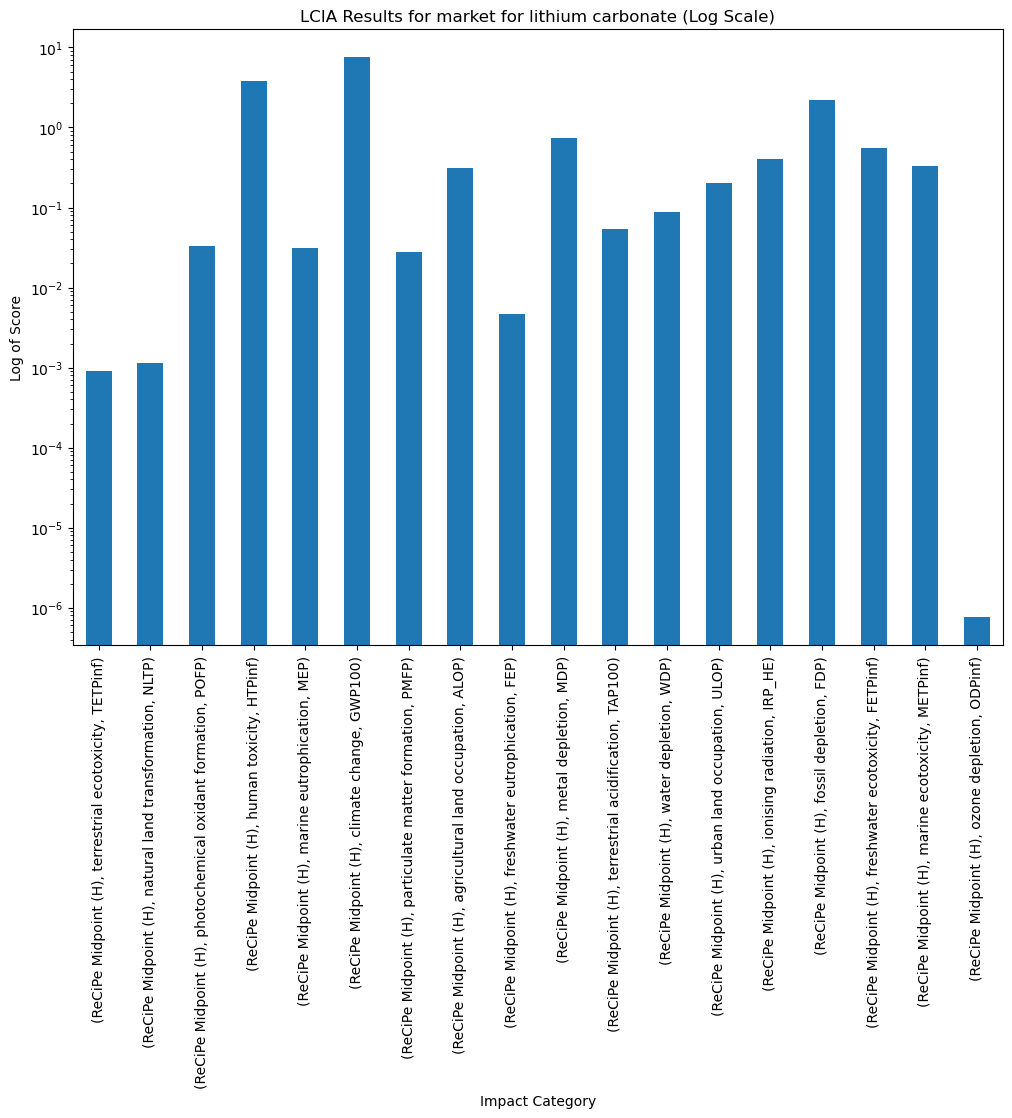

In [33]:
plot_lcia_log_bar(lcia_results, activity_name)

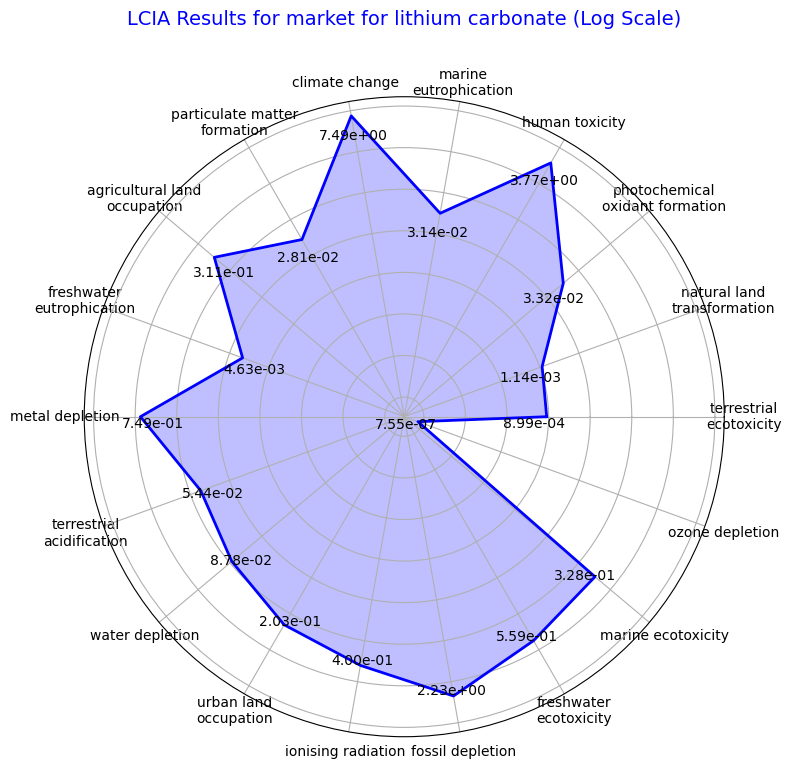

In [34]:
plot_lcia_radar_log(lcia_results, activity_name)

In [71]:
'''
Let's explore the activiies:
    'lithium carbonate production, from concentrated brine',
    'lithium carbonate production, from spodumene', # From RoW
    'lithium carbonate production, from spodumene' # From CN
'''

"\nLet's explore the activiies:\n'lithium carbonate production, from Salar de Atacama'\n'lithium carbonate production, from Salar de Olaroz'\n'lithium carbonate production, from Salar de Cauchari-Olaroz'\n'lithium carbonate production, from Salar del Hombre Muerto'\n'lithium carbonate production, from Chaerhan salt lake'\n"

### 3.1.1. lithium carbonate production, from concentrated brine

In [39]:
activity_name = 'lithium carbonate production, from concentrated brine'
activity = find_activity_by_name_product_location(db_name, activity_name)

In [40]:
# To view the inventory
for exc in activity.exchanges():
    print(f"Input: {exc.input} | Amount: {exc['amount']}")

Input: 'market for lithium brine, 6.7 % Li' (kilogram, GLO, None) | Amount: 4.19
Input: 'market for diesel, burned in building machine' (megajoule, GLO, None) | Amount: 1.88
Input: 'market for 2-methyl-2-butanol' (kilogram, GLO, None) | Amount: 0.000545
Input: 'lithium carbonate production, from concentrated brine' (kilogram, GLO, None) | Amount: 1.0
Input: 'market group for electricity, medium voltage' (kilowatt hour, GLO, None) | Amount: 0.58
Input: 'market for chemical factory, organics' (unit, GLO, None) | Amount: 4e-10
Input: 'market group for heat, district or industrial, natural gas' (megajoule, GLO, None) | Amount: 2.963532477
Input: 'market for soda ash, light, crystalline, heptahydrate' (kilogram, GLO, None) | Amount: 2.12
Input: 'market for sodium hydroxide, without water, in 50% solution state' (kilogram, GLO, None) | Amount: 0.0001875
Input: 'market for solvent, organic' (kilogram, GLO, None) | Amount: 2.08e-05
Input: 'market for activated bentonite' (kilogram, GLO, None) 

In [41]:
# Select ReCiPe Midpoint (H) method
method = ('ReCiPe Midpoint (H)', 'climate change', 'GWP100')  # Example impact category, you can choose others

In [42]:
# Perform the LCIA
lca = bc.LCA({activity: 1}, method)
lca.lci()  # Run Life Cycle Inventory
lca.lcia()  # Run Life Cycle Impact Assessment

# Print the total LCIA score
print(f"LCIA Score: {lca.score}")

LCIA Score: 2.0750005807610377


In [43]:
# Perform contribution analysis
contributions = bwa.ContributionAnalysis().annotated_top_processes(lca, limit=10)  # Adjust the limit as an integer
for contribution in contributions:
    print(f"Contribution: {contribution[1]} | Activity: {contribution[2]} | Amount: {contribution[0]}")


Contribution: 3.4540148878595733 | Activity: 'heat production, at hard coal industrial furnace 1-10MW' (megajoule, RoW, None) | Amount: 0.39741896220174217
Contribution: 2.768871770594094 | Activity: 'diesel, burned in building machine' (megajoule, GLO, None) | Amount: 0.20469756456665572
Contribution: 0.07316437859964213 | Activity: 'quicklime production, in pieces, loose' (kilogram, RoW, None) | Amount: 0.07895069015632566
Contribution: 0.19697443106524148 | Activity: 'hard coal mine operation and hard coal preparation' (kilogram, CN, None) | Amount: 0.06731008316025265
Contribution: 0.43127726126042487 | Activity: 'heat production, at hard coal industrial furnace 1-10MW' (megajoule, Europe without Switzerland, None) | Amount: 0.04962276282993718
Contribution: 0.4098898415776502 | Activity: 'heat production, heavy fuel oil, at industrial furnace 1MW' (megajoule, RoW, None) | Amount: 0.034220797723836155
Contribution: 0.9039554791906274 | Activity: 'heat and power co-generation, natur

In [44]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0002797777897757939
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0006095939942018101
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.009979032046893706
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 1.4385872881992887
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.008521145786293538
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 2.0750005807610377
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.005997127751129837
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.2098621650192447
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0019771462377554737
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.23922365147498964
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.015534855771410288
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.00531976119209747
('ReCiPe Midpoint (H)', 'urban land oc

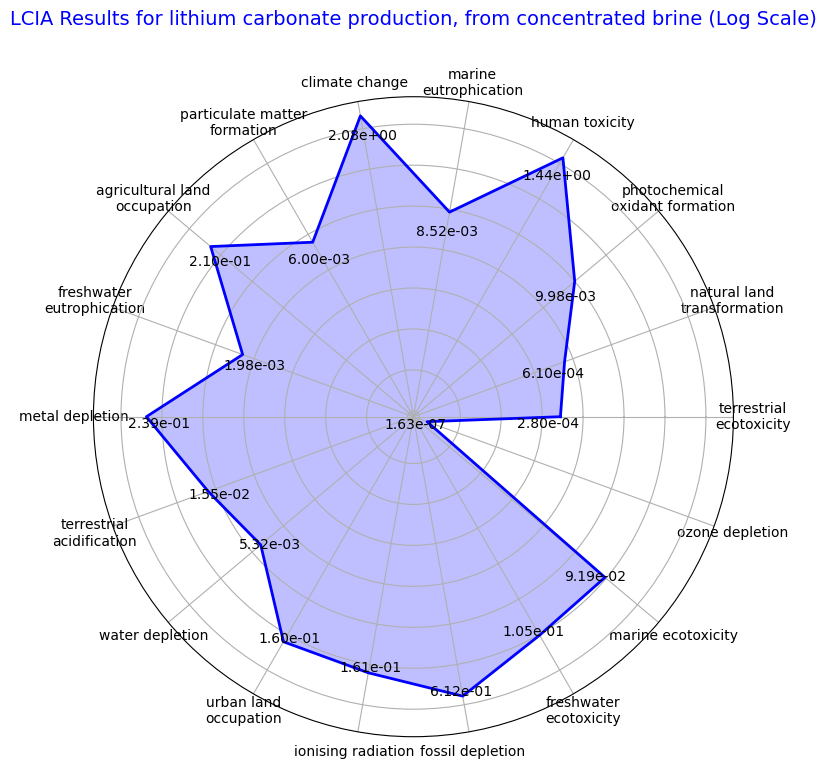

In [45]:
plot_lcia_radar_log(lcia_results, activity_name)

### 3.1.2. lithium carbonate production, from Salar de Olaroz

In [55]:
activity_name = 'lithium carbonate production, from spodumene'
activity = find_activity_by_name_product_location(db_name, activity_name, location='CN')

In [56]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0013002486183886217
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0013178490864091579
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.04672564126359646
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 5.476061844817882
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0437248728658749
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 10.57063894999183
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.04050281981843297
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.3581611434592436
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.00602597993419421
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 1.155553039466559
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.07579807844922382
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.14193131426288438
('ReCiPe Midpoint (H)', 'urban land occupation', 

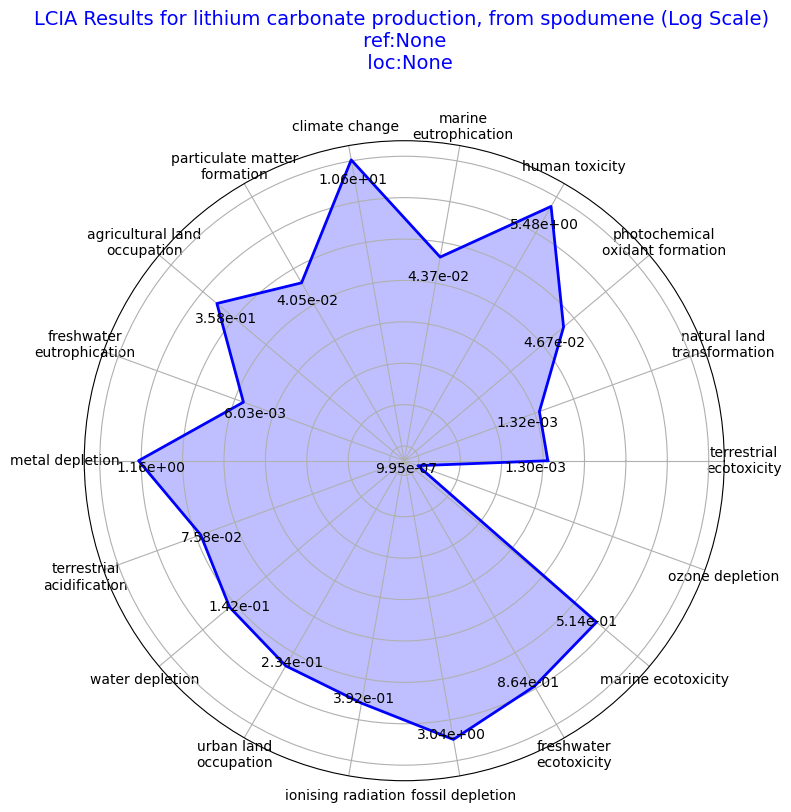

In [57]:
plot_lcia_radar_log(lcia_results, activity_name)

### 3.1.3. lithium carbonate production, from spodumene (RoW)

In [58]:
activity_name = 'lithium carbonate production, from spodumene'
activity = find_activity_by_name_product_location(db_name, activity_name, location='RoW')

In [59]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0007860549095104445
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0016725357967039924
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.035543640965350114
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 2.9261856733505414
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.03976781489612506
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 8.869917489760297
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.03469958381950744
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.37435726759067756
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.005867939439985131
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.43409771375600126
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.06651657358002626
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.08520613709366304
('ReCiPe Midpoint (H)', 'urban land occupa

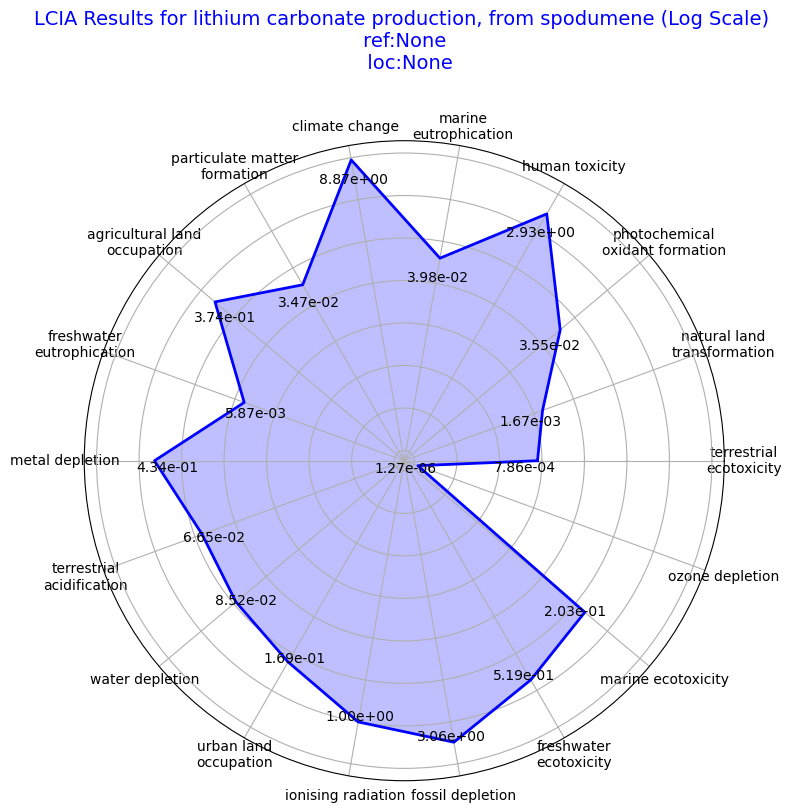

In [60]:
plot_lcia_radar_log(lcia_results, activity_name)

## 3.2. All compared

### 3.2.1. Midpoint

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0002797777897757939
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0006095939942018101
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.009979032046893706
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 1.4385872881992887
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.008521145786293538
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 2.0750005807610377
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.005997127751129837
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.2098621650192447
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0019771462377554737
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.23922365147498964
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.015534855771410288
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.00531976119209747
('ReCiPe Midpoint (H)', 'urban land oc

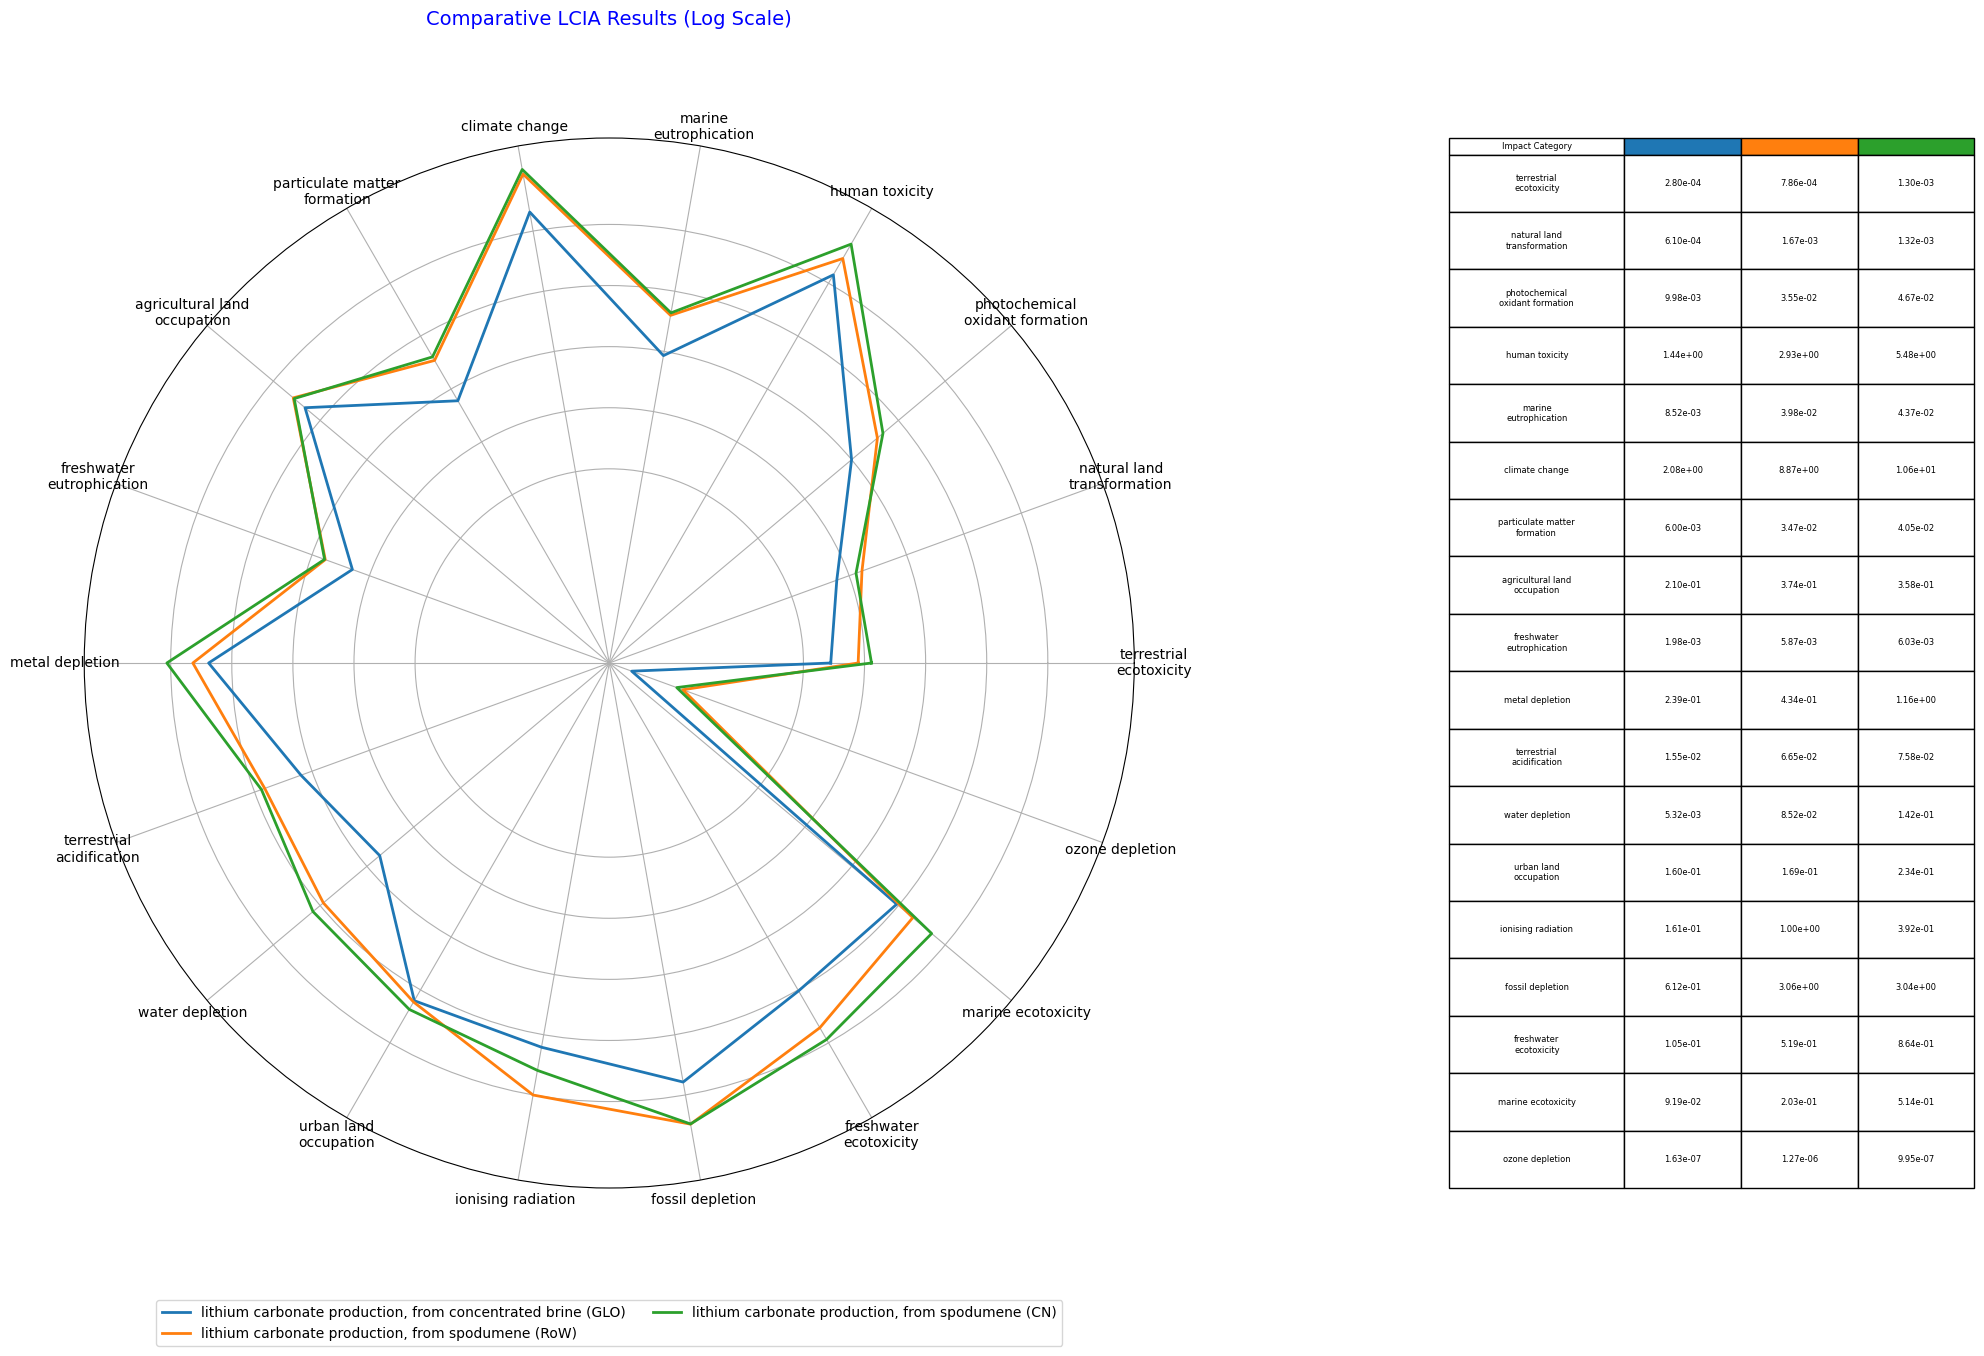

In [85]:
# Run LCIA for all activities

comparative_results = run_comparative_lcia(activities_li, db_name, recipe_midpoint_h, reference_product_lithium)

plot_comparative_radar_log_with_colored_table(comparative_results, recipe_midpoint_h)

### 3.2.2. Endpoint

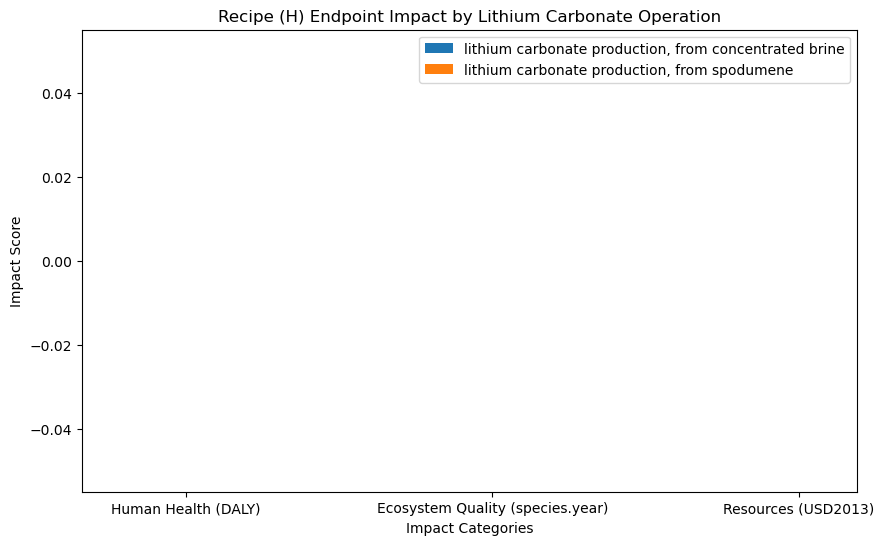

In [63]:
# Extracting the results into a matrix and list of operations
operations = list(comparative_results.keys())
categories = ['Human Health (DALY)', 'Ecosystem Quality (species.year)', 'Resources (USD2013)']
data = np.array([[comparative_results[op][('ReCiPe Endpoint (H,A)', 'human health', 'total')],
                  comparative_results[op][('ReCiPe Endpoint (H,A)', 'ecosystem quality', 'total')],
                  comparative_results[op][('ReCiPe Endpoint (H,A)', 'resources', 'total')]] for op in operations])

# Bar Plot
x = np.arange(len(categories))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each operation's results as grouped bars
for i, operation in enumerate(operations):
    ax.bar(x + i * width, data[i], width, label=operation)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Impact Categories')
ax.set_ylabel('Impact Score')
ax.set_title('Recipe (H) Endpoint Impact by Lithium Carbonate Operation')
ax.set_xticks(x + width / 2 * len(operations))
ax.set_xticklabels(categories)
ax.legend()

plt.show()

# 4. Nickel

## 4.1. Nickel, Class 1

In [88]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
activity_name = "market for nickel, class 1"
reference_product = reference_product_nickel
activity = find_activity_by_name_product_location(db_name, activity_name)

In [89]:
list(activity.exchanges())

[Exchange: 0.3614 ton kilometer 'market group for transport, freight, lorry, unspecified' (ton kilometer, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 1.0 kilogram 'market for nickel, class 1' (kilogram, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 0.3633 ton kilometer 'market for transport, freight, sea, container ship' (ton kilometer, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 0.3448 ton kilometer 'market group for transport, freight train' (ton kilometer, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 0.0363 ton kilometer 'market group for transport, freight, inland waterways, barge' (ton kilometer, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 5.36263530789971e-06 kilogram 'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining' (kilogram, SE, None) to 'market for nickel, class 1' (kilog

In [90]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.018185638952099497
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.006598583214945175
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.22996165198742105
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 31.543934897062407
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.037257738208639146
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 16.665447132368275
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.33198831031399767
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.5348035959036505
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.014850347634082618
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 60.51389276958162
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 1.5259747435555246
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.2354131523753126
('ReCiPe Midpoint (H)', 'urban land occupation',

In [91]:
'''
Let's explore the activities:
'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining'
'platinum group metal mine operation, ore with high palladium content'
'platinum group metal, extraction and refinery operations'
'processing of nickel-rich materials'
'smelting and refining of nickel concentrate, 16% Ni'
'smelting and refining of nickel concentrate, 7% Ni'
'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining'
'cobalt production'
'''

"\nLet's explore the activities:\n'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining'\n'platinum group metal mine operation, ore with high palladium content'\n'platinum group metal, extraction and refinery operations'\n'processing of nickel-rich materials'\n'smelting and refining of nickel concentrate, 16% Ni'\n'smelting and refining of nickel concentrate, 7% Ni'\n'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining'\n'cobalt production'\n"

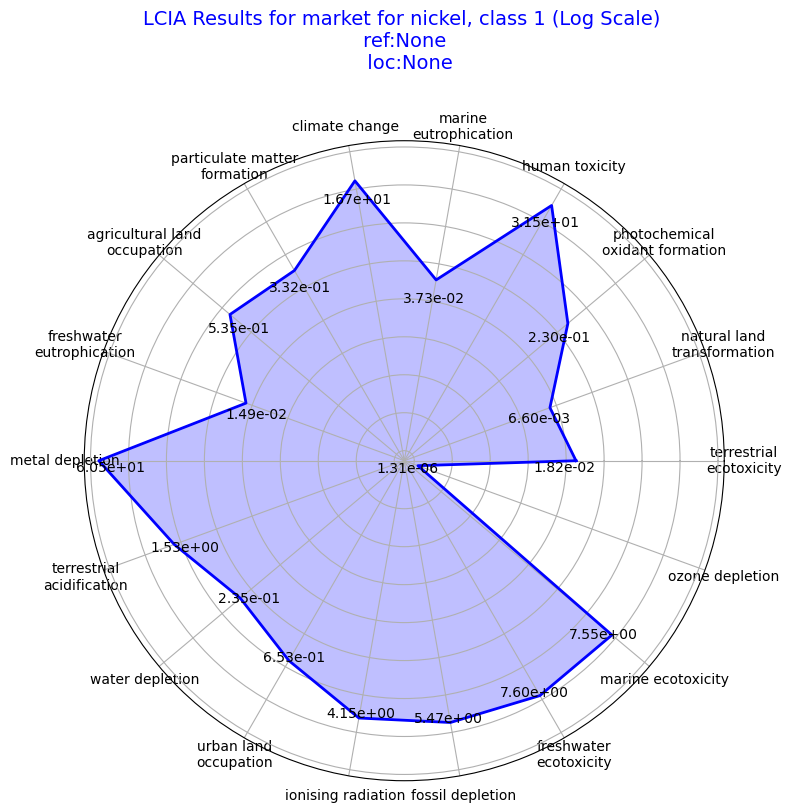

In [92]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.1. treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining

In [93]:
activity_name = 'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining'

In [94]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 6.013810443539406e-05
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 7.203041474584177e-05
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.002017027601485211
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 11.438735166063351
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0006042015259726486
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 1.0150710291036262
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.0010706628110376643
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.0073518096098569834
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 9.079627208614287e-05
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.014470073416913818
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.0022314730722373007
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.001175762319192224
('ReCiPe Midpoint (H)', 'urban

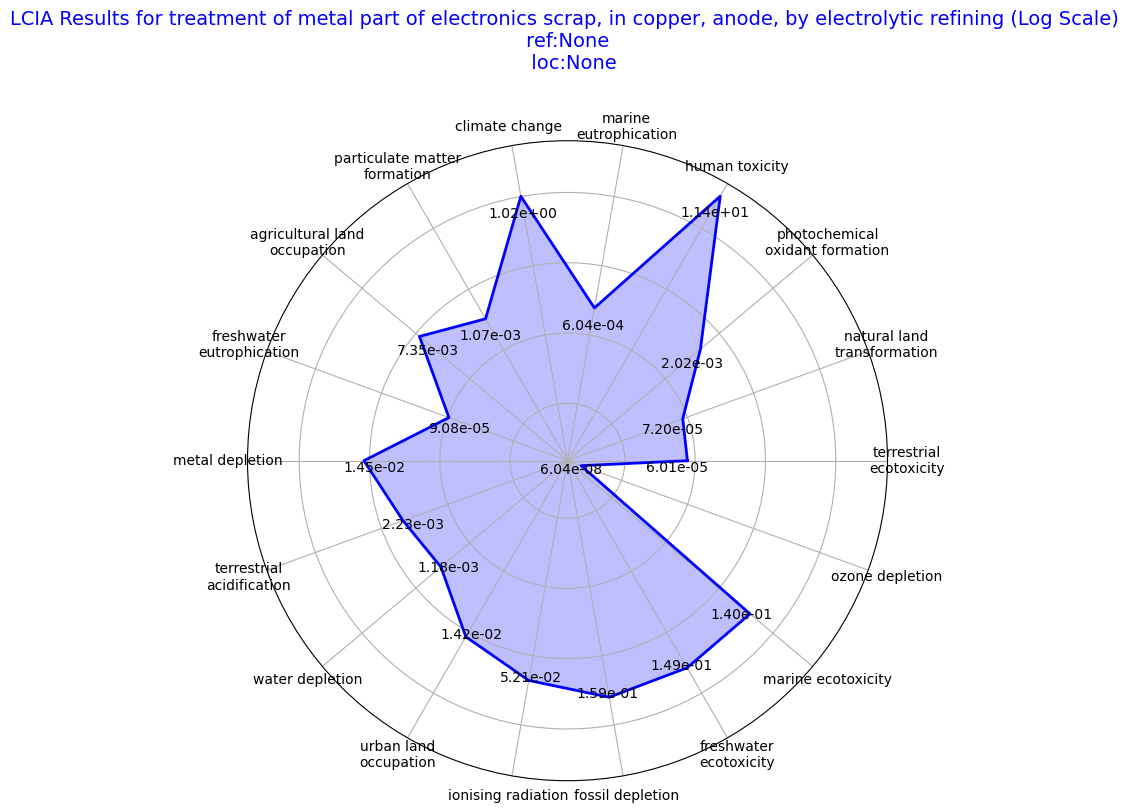

In [95]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.2. platinum group metal mine operation, ore with high palladium content

In [96]:
activity_name = 'platinum group metal mine operation, ore with high palladium content'

In [97]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0014029415177698743
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0008144864306491738
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.6101730428782778
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 11.237439143042863
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.00745356508146784
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 8.262289239295177
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 1.4757295953689784
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.17857714204646377
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.004782434045587701
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 57.831685949491224
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 7.294171610256576
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.2699124712787351
('ReCiPe Midpoint (H)', 'urban land occupation', 

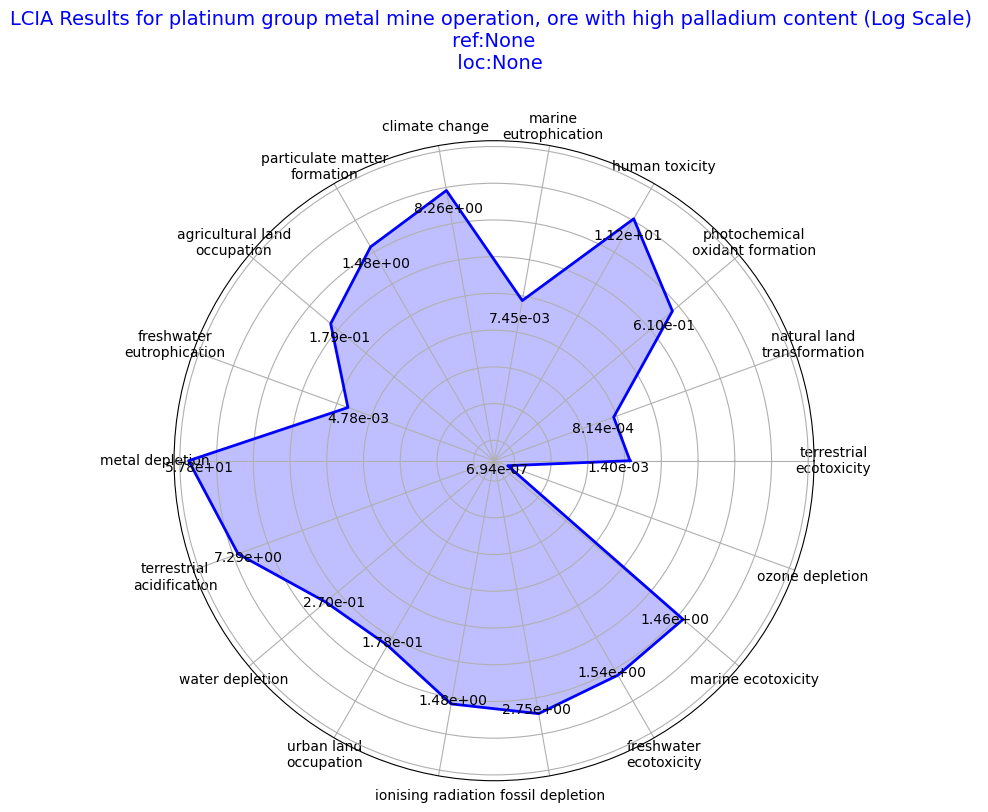

In [98]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.3. platinum group metal, extraction and refinery operations


In [99]:
activity_name = 'platinum group metal, extraction and refinery operations'

In [100]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0025859145422173326
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.051589467679627424
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.9194678551078268
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 192.99883894243087
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.2977475995013448
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 49.70037769201053
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.313624488768408
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.6647989359620069
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0650485336362337
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 79.72484903956877
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 1.1354332907383942
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.528519100903807
('ReCiPe Midpoint (H)', 'urban land occupation', 'ULOP')

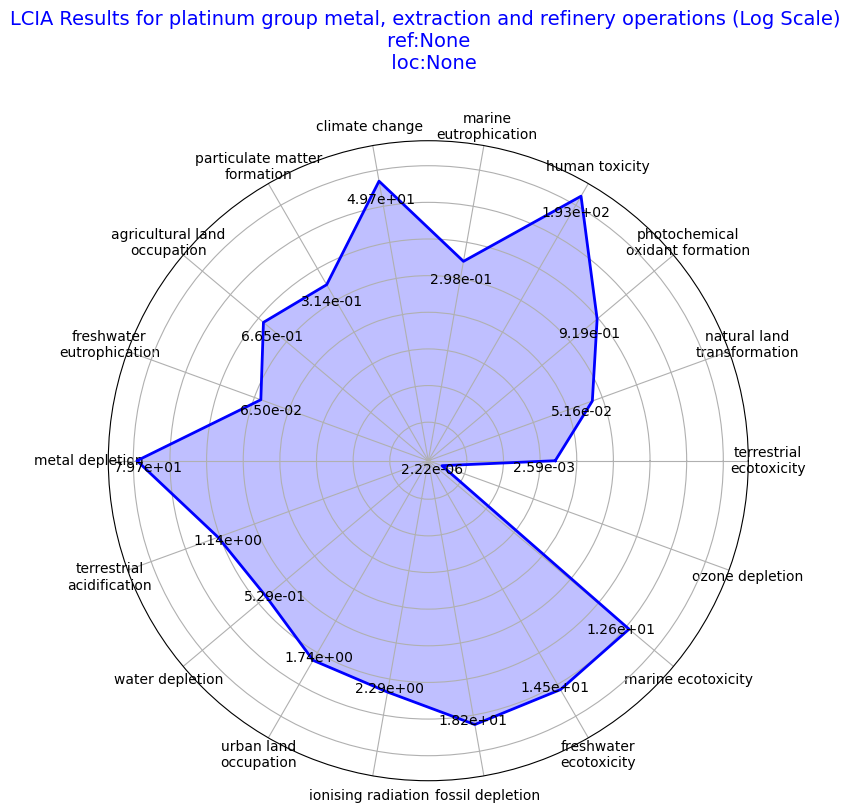

In [101]:
plot_lcia_radar_log(lcia_results, activity_name)

#### test ahead

In [102]:
# To view the inventory
for exc in activity.exchanges():
    print(f"Input: {exc.input} | Amount: {exc['amount']}")

Input: 'market for electricity, medium voltage' (kilowatt hour, ZA, None) | Amount: 14.7230439927967
Input: 'market for hard coal' (kilogram, ZA, None) | Amount: 1.04601675082643
Input: 'market for lubricating oil' (kilogram, RoW, None) | Amount: 1.67649260063963
Input: 'market for tap water' (kilogram, ZA, None) | Amount: 43.7034395893236
Input: 'market for platinum group metal concentrate' (kilogram, ZA, None) | Amount: 4.04794153573243
Input: 'market for non-ferrous metal smelter' (unit, GLO, None) | Amount: 2.70358426163462e-15
Input: 'platinum group metal, extraction and refinery operations' (kilogram, ZA, None) | Amount: 1.0
Input: 'market for diesel, burned in building machine' (megajoule, GLO, None) | Amount: 18.4485831053292
Input: 'market for inert waste' (kilogram, RoW, None) | Amount: -3.83300658693248
Input: 'Dissolved solids' (kilogram, None, ('water', 'surface water')) | Amount: 3.40671893847924e-06
Input: 'Dioxins, measured as 2,3,7,8-tetrachlorodibenzo-p-dioxin' (kilog

In [103]:
# Select ReCiPe Midpoint (H) method
method = ('ReCiPe Midpoint (H)', 'climate change', 'GWP100')  # Example impact category, you can choose others

In [104]:
# Perform the LCIA
lca = bc.LCA({activity: 1}, method)
lca.lci()  # Run Life Cycle Inventory
lca.lcia()  # Run Life Cycle Impact Assessment

# Print the total LCIA score
print(f"LCIA Score: {lca.score}")

LCIA Score: 49.70037769201053


In [105]:
# Perform contribution analysis
contributions = bwa.ContributionAnalysis().annotated_top_processes(lca, limit=10)  # Adjust the limit as an integer
for contribution in contributions:
    print(f"Contribution: {contribution[1]} | Activity: {contribution[2]} | Amount: {contribution[0]}")


Contribution: 32.23405219823658 | Activity: 'electricity production, hard coal, conventional' (kilowatt hour, ZA, None) | Amount: 34.18098647139265
Contribution: 32.378117542982814 | Activity: 'diesel, burned in building machine' (megajoule, GLO, None) | Amount: 2.393654295113651
Contribution: 0.6371441257702996 | Activity: 'electricity production, hard coal, supercritical' (kilowatt hour, ZA, None) | Amount: 0.5975855834728449
Contribution: 37.44288102440216 | Activity: 'market for electricity, high voltage' (kilowatt hour, ZA, None) | Amount: 0.5578989131698799
Contribution: 4.737629256523911 | Activity: 'heat production, at hard coal industrial furnace 1-10MW' (megajoule, RoW, None) | Amount: 0.5451116348809705
Contribution: 0.3347964982433558 | Activity: 'nitric acid production, product in 50% solution state' (kilogram, RNA, None) | Amount: 0.5105898648965329
Contribution: 0.21776102562987115 | Activity: 'nitric acid production, product in 50% solution state' (kilogram, CN, None) |

### 4.1.4. processing of nickel-rich materials


In [106]:
activity_name = 'processing of nickel-rich materials'

In [107]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0027436391582154134
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.004274171620801637
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.03215753747653277
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 17.19336286876104
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.011977426144184882
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 5.292509578989338
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.014240498850281414
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.1673164699747478
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.011288109000367901
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 36.024990515630414
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.02871718421051971
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.11434834273390854
('ReCiPe Midpoint (H)', 'urban land occupatio

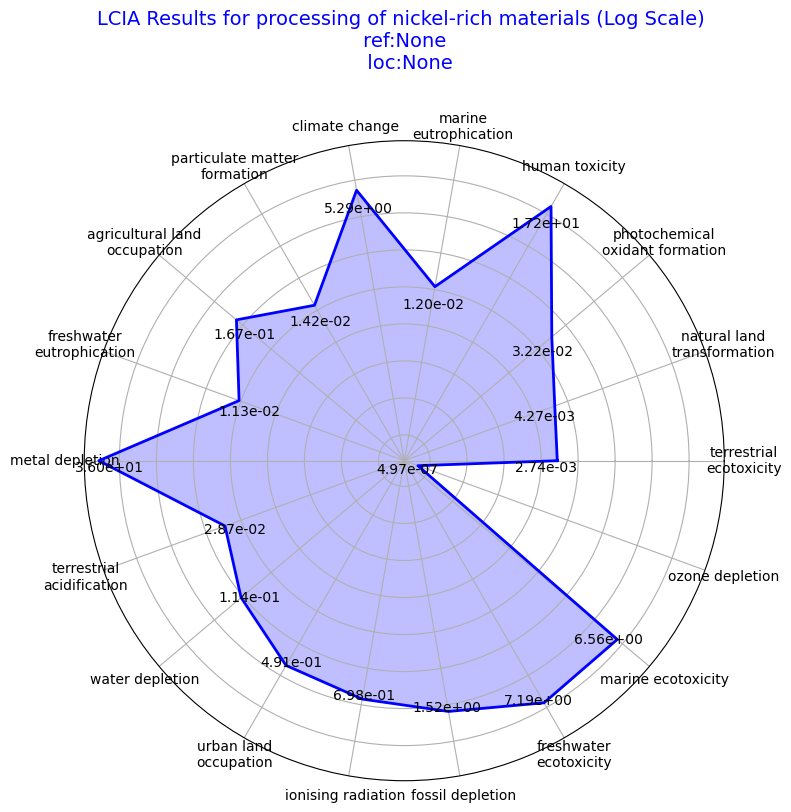

In [108]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.5. smelting and refining of nickel concentrate, 16% Ni

In [109]:
activity_name = 'smelting and refining of nickel concentrate, 16% Ni'

In [110]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0025418633250516294
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.004094266884222111
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.1512937911297459
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 17.022610853609258
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.015611397222239837
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 10.195098001338886
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.28748071557332694
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.7390227104503608
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.011435986207742905
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 28.607648188545387
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 1.3703700533586456
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.11181702810220508
('ReCiPe Midpoint (H)', 'urban land occupation

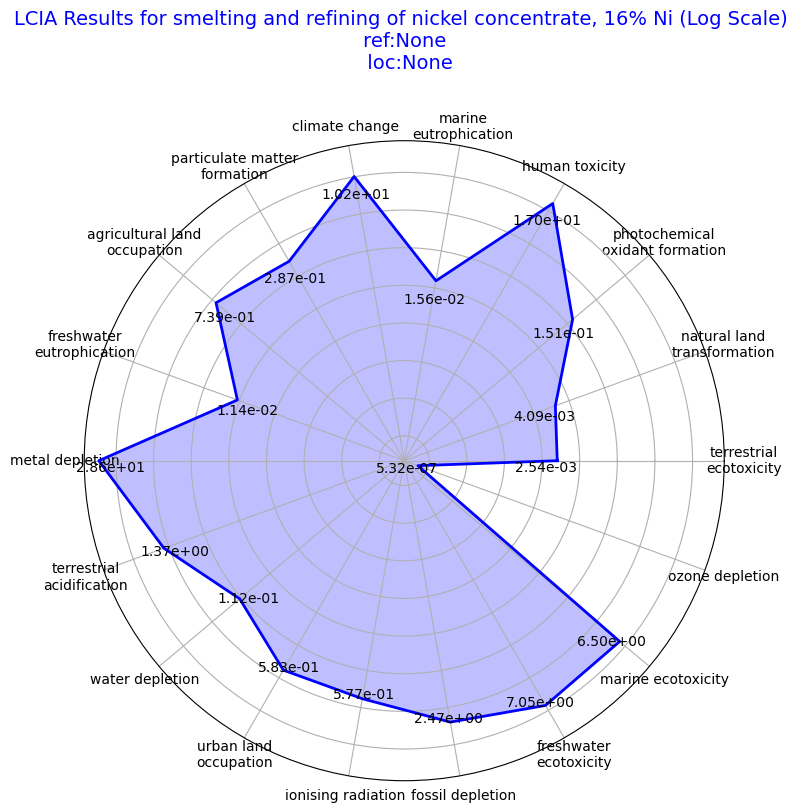

In [111]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.6. smelting and refining of nickel concentrate, 7% Ni


In [112]:
activity_name = 'smelting and refining of nickel concentrate, 7% Ni'

In [113]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.06039155409153166
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.009219106755592158
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.3074478200694202
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 50.94518660806431
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.07316719760827686
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 32.791686431193085
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.08726017164971515
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.578842786829514
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.03686770189496038
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 15.11847226430332
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.20875915635146344
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.054145993002128
('ReCiPe Midpoint (H)', 'urban land occupation', 'ULOP

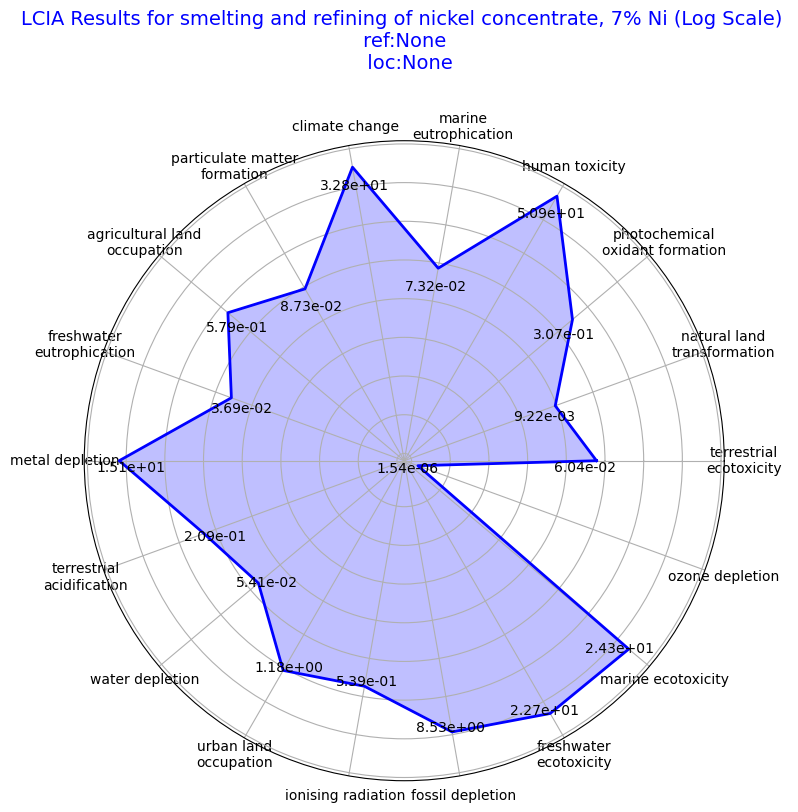

In [114]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.7. treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining


In [115]:
activity_name = 'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining'

In [116]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 6.013810443539406e-05
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 7.203041474584177e-05
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.002017027601485211
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 11.438735166063351
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0006042015259726486
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 1.0150710291036262
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.0010706628110376643
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.0073518096098569834
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 9.079627208614287e-05
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.014470073416913818
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.0022314730722373007
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.001175762319192224
('ReCiPe Midpoint (H)', 'urban

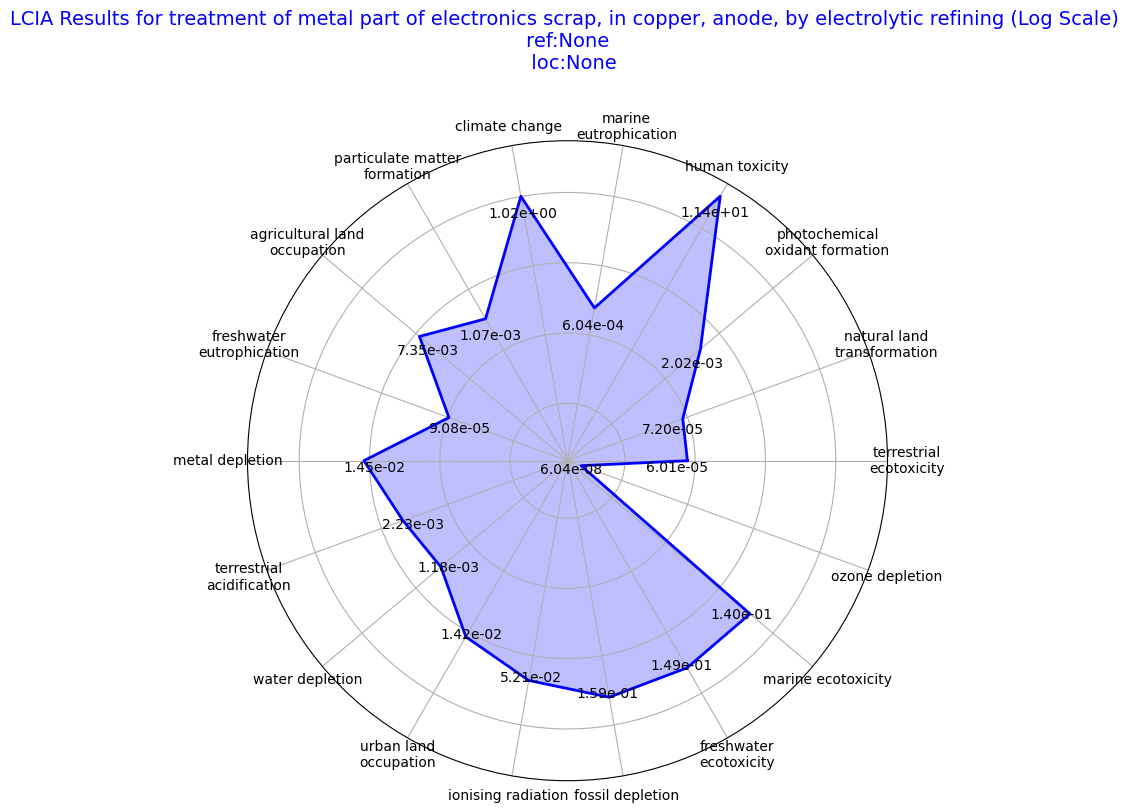

In [117]:
plot_lcia_radar_log(lcia_results, activity_name)

### 4.1.8. cobalt production


In [118]:
activity_name = 'cobalt production'

In [119]:
activity = find_activity_by_name_product_location(db_name, activity_name, reference_product)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0205912245721835
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.006056523781210254
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.0654670910721685
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 29.75531539038718
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.03022796070484066
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 17.334145527309772
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.0626050473636233
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.7251293837065044
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.007273335724420902
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 108.49319587402675
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.16036262337785825
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.3930469295154802
('ReCiPe Midpoint (H)', 'urban land occupation', 'UL

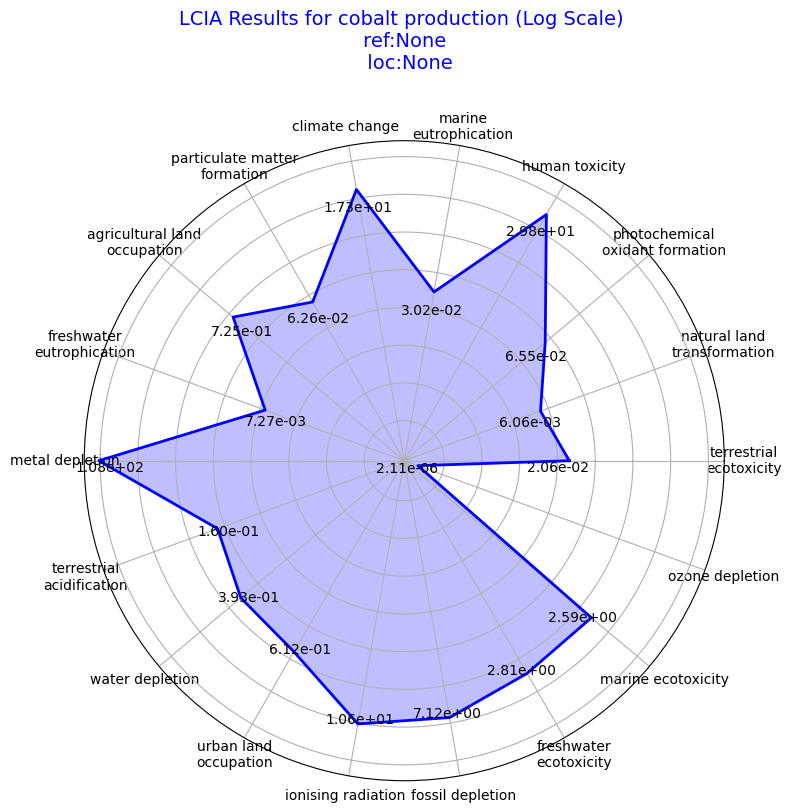

In [120]:
plot_lcia_radar_log(lcia_results, activity_name)

## 4.2. From Cobalt Production

## 4.3. All Compared

In [121]:
activities = activities_ni

In [122]:
# Run LCIA for all activities
comparative_results = run_comparative_lcia(activities, db_name, recipe_midpoint_h, reference_product)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 6.013810443539406e-05
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 7.203041474584177e-05
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.002017027601485211
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 11.438735166063351
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0006042015259726486
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 1.0150710291036262
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.0010706628110376643
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.0073518096098569834
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 9.079627208614287e-05
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.014470073416913818
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.0022314730722373007
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.001175762319192224
('ReCiPe Midpoint (H)', 'urban

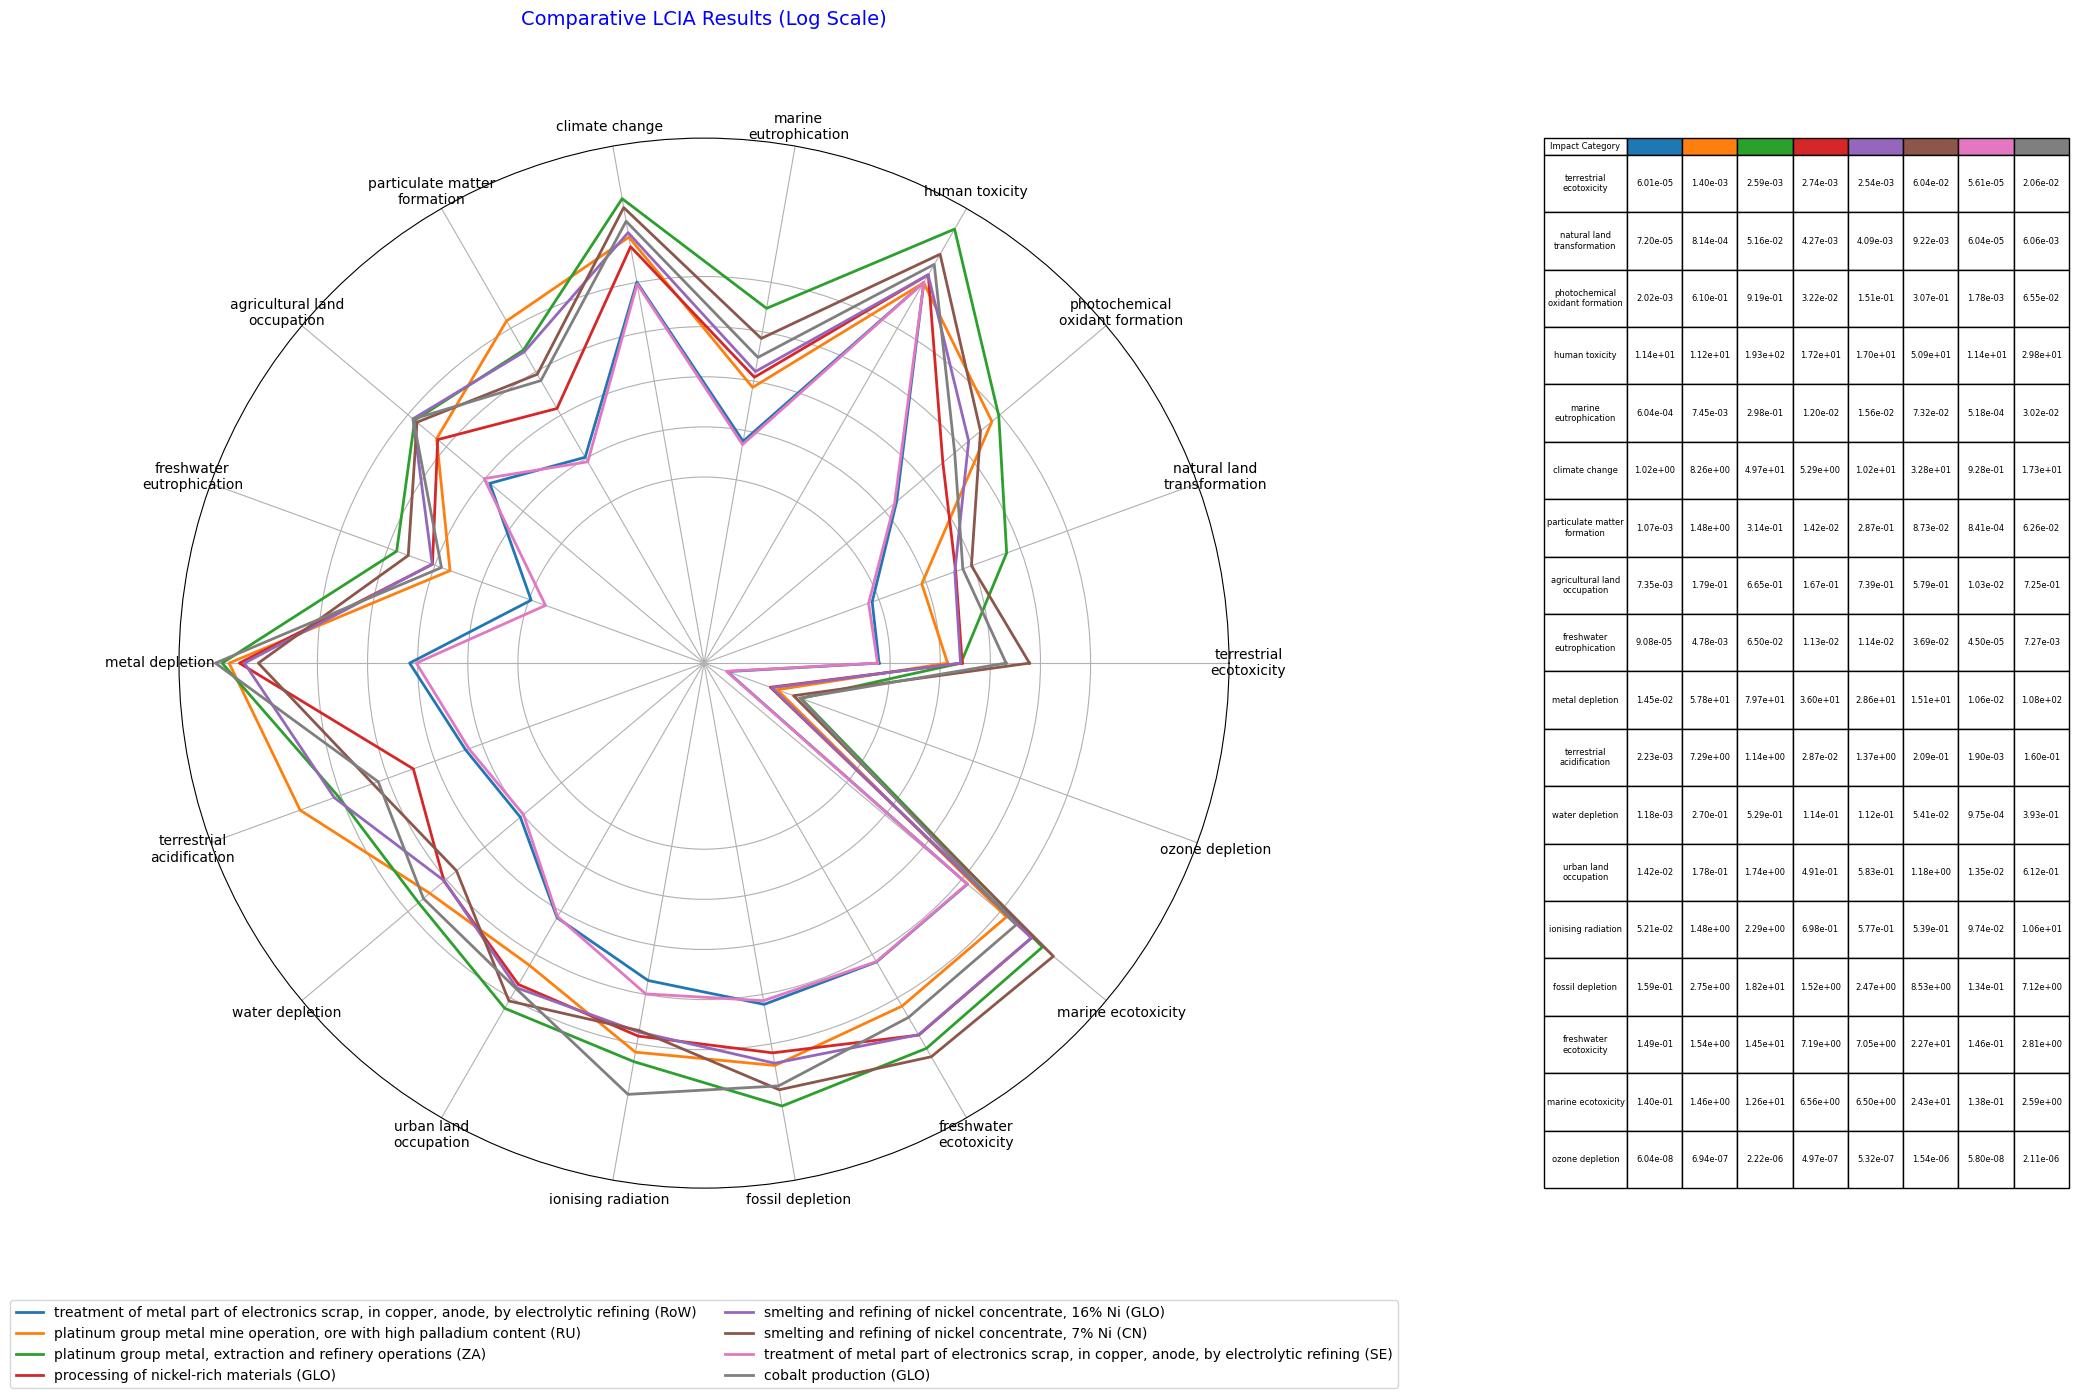

In [123]:
plot_comparative_radar_log_with_colored_table(comparative_results, recipe_midpoint_h)

# 5. Manganese

In [80]:
'''
When looking at NMC-811 hydroxide, we can see "manganese sulfate".
By exploring manganese sulfate, we can see:
-manganese dioxide production
-manganese sulfate production
both generating manganese sulfate

'''

'\nWhen looking at NMC-811 hydroxide, we can see "manganese sulfate".\nBy exploring manganese sulfate, we can see:\n-manganese dioxide production\n-manganese sulfate production\nboth generating manganese sulfate\n\n'

## 5.1. Manganese Sulfate

In [124]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
activity_name = "market for manganese sulfate"
activity = find_activity_by_name_product_location(db_name, activity_name)

In [125]:
list(activity.exchanges())

[Exchange: 0.599 ton kilometer 'market for transport, freight, sea, container ship' (ton kilometer, GLO, None) to 'market for manganese sulfate' (kilogram, GLO, None)>,
 Exchange: 0.2088 ton kilometer 'market group for transport, freight, lorry, unspecified' (ton kilometer, GLO, None) to 'market for manganese sulfate' (kilogram, GLO, None)>,
 Exchange: 0.3091 ton kilometer 'market group for transport, freight train' (ton kilometer, GLO, None) to 'market for manganese sulfate' (kilogram, GLO, None)>,
 Exchange: 0.0246 ton kilometer 'market group for transport, freight, inland waterways, barge' (ton kilometer, GLO, None) to 'market for manganese sulfate' (kilogram, GLO, None)>,
 Exchange: 1.0 kilogram 'market for manganese sulfate' (kilogram, GLO, None) to 'market for manganese sulfate' (kilogram, GLO, None)>,
 Exchange: 0.138175528006351 kilogram 'manganese dioxide production' (kilogram, GLO, None) to 'market for manganese sulfate' (kilogram, GLO, None)>,
 Exchange: 0.861824471993649 ki

In [126]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.00010668289030403346
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.00024230828388675918
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.004753948141938813
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 1.919861384042555
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0011158401915370042
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 0.7981935309507185
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.005606424962330622
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.03500297944713388
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0003556475910024787
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 41.79675204367337
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.022205910795353598
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.00579610171478248
('ReCiPe Midpoint (H)', 'urban land o

In [127]:
'''
Let's explore the activities:
'manganese dioxide production'
'manganese sulfate production'
'''

"\nLet's explore the activities:\n'manganese dioxide production'\n'manganese sulfate production'\n"

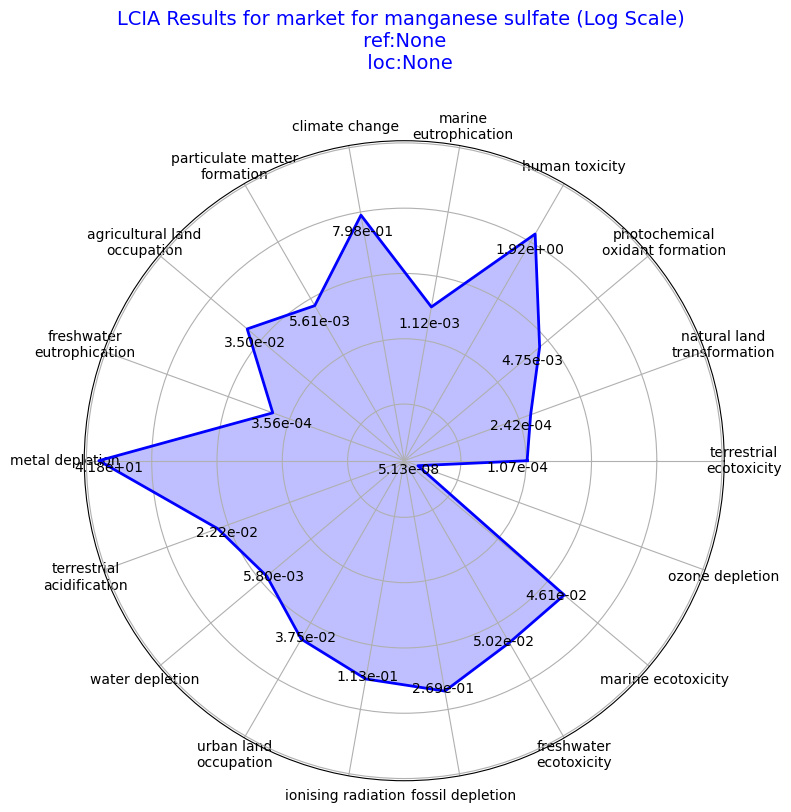

In [128]:
plot_lcia_radar_log(lcia_results, activity_name)

### 5.1.1. Manganese dioxide production

In [129]:
activity_name = 'manganese dioxide production'

In [130]:
activity = find_activity_by_name_product_location(db_name, activity_name)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.00025260741665591855
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0005093293126839417
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.007443805771401885
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 5.589791834393479
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0025473042564663935
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 2.5487712609567383
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.004902713499816977
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.11179261663907417
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0013695554476023135
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 91.32190690398524
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.013531030167962987
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.01296616423564468
('ReCiPe Midpoint (H)', 'urban land oc

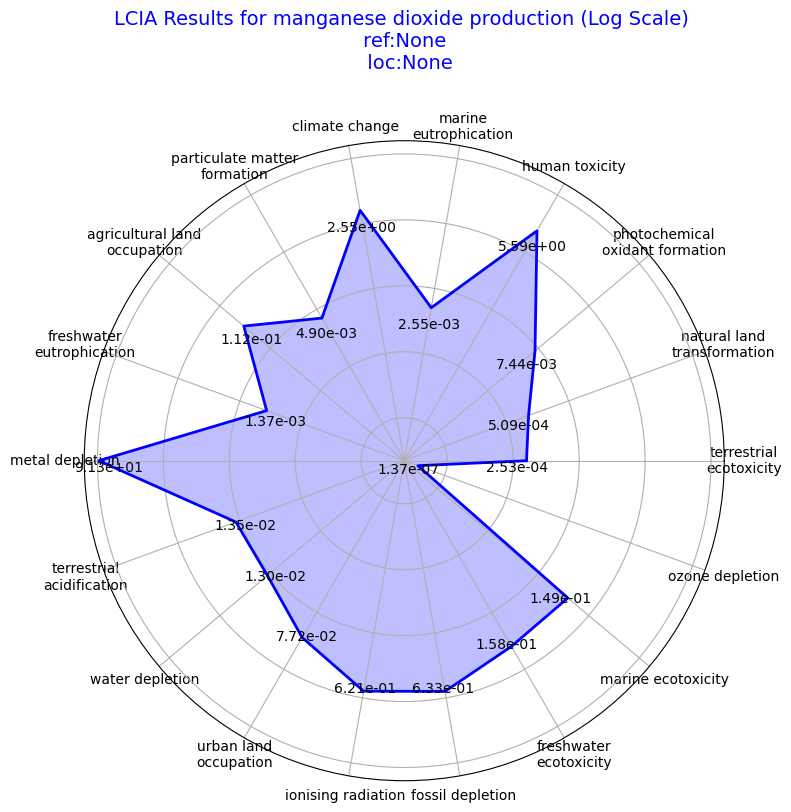

In [131]:
plot_lcia_radar_log(lcia_results, activity_name)

### 5.1.2. Manganese sulfate production

In [132]:
activity_name = 'manganese sulfate production'

In [133]:
activity = find_activity_by_name_product_location(db_name, activity_name)
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 8.889824077463508e-05
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.00022820126205310462
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.004484550343703462
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 1.857749664347986
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0009454484118726572
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 0.7064798602991345
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.00599361353522561
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.03247817919150531
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0003189202622488399
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 42.67970394822428
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.024468201890138267
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.0058336316152647555
('ReCiPe Midpoint (H)', 'urban land o

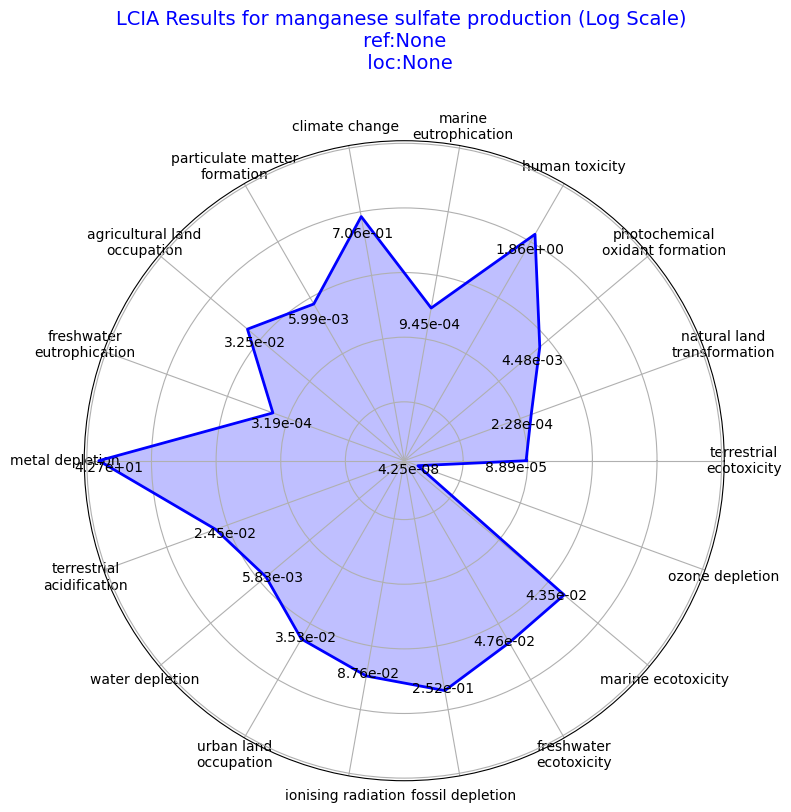

In [134]:
plot_lcia_radar_log(lcia_results, activity_name)

## 5.2. All Compared

In [135]:
activities = activities_mn

In [136]:
# Run LCIA for all activities

comparative_results = run_comparative_lcia(activities, db_name, recipe_midpoint_h)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.00025260741665591855
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0005093293126839417
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.007443805771401885
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 5.589791834393479
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0025473042564663935
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 2.5487712609567383
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.004902713499816977
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.11179261663907417
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0013695554476023135
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 91.32190690398524
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.013531030167962987
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.01296616423564468
('ReCiPe Midpoint (H)', 'urban land oc

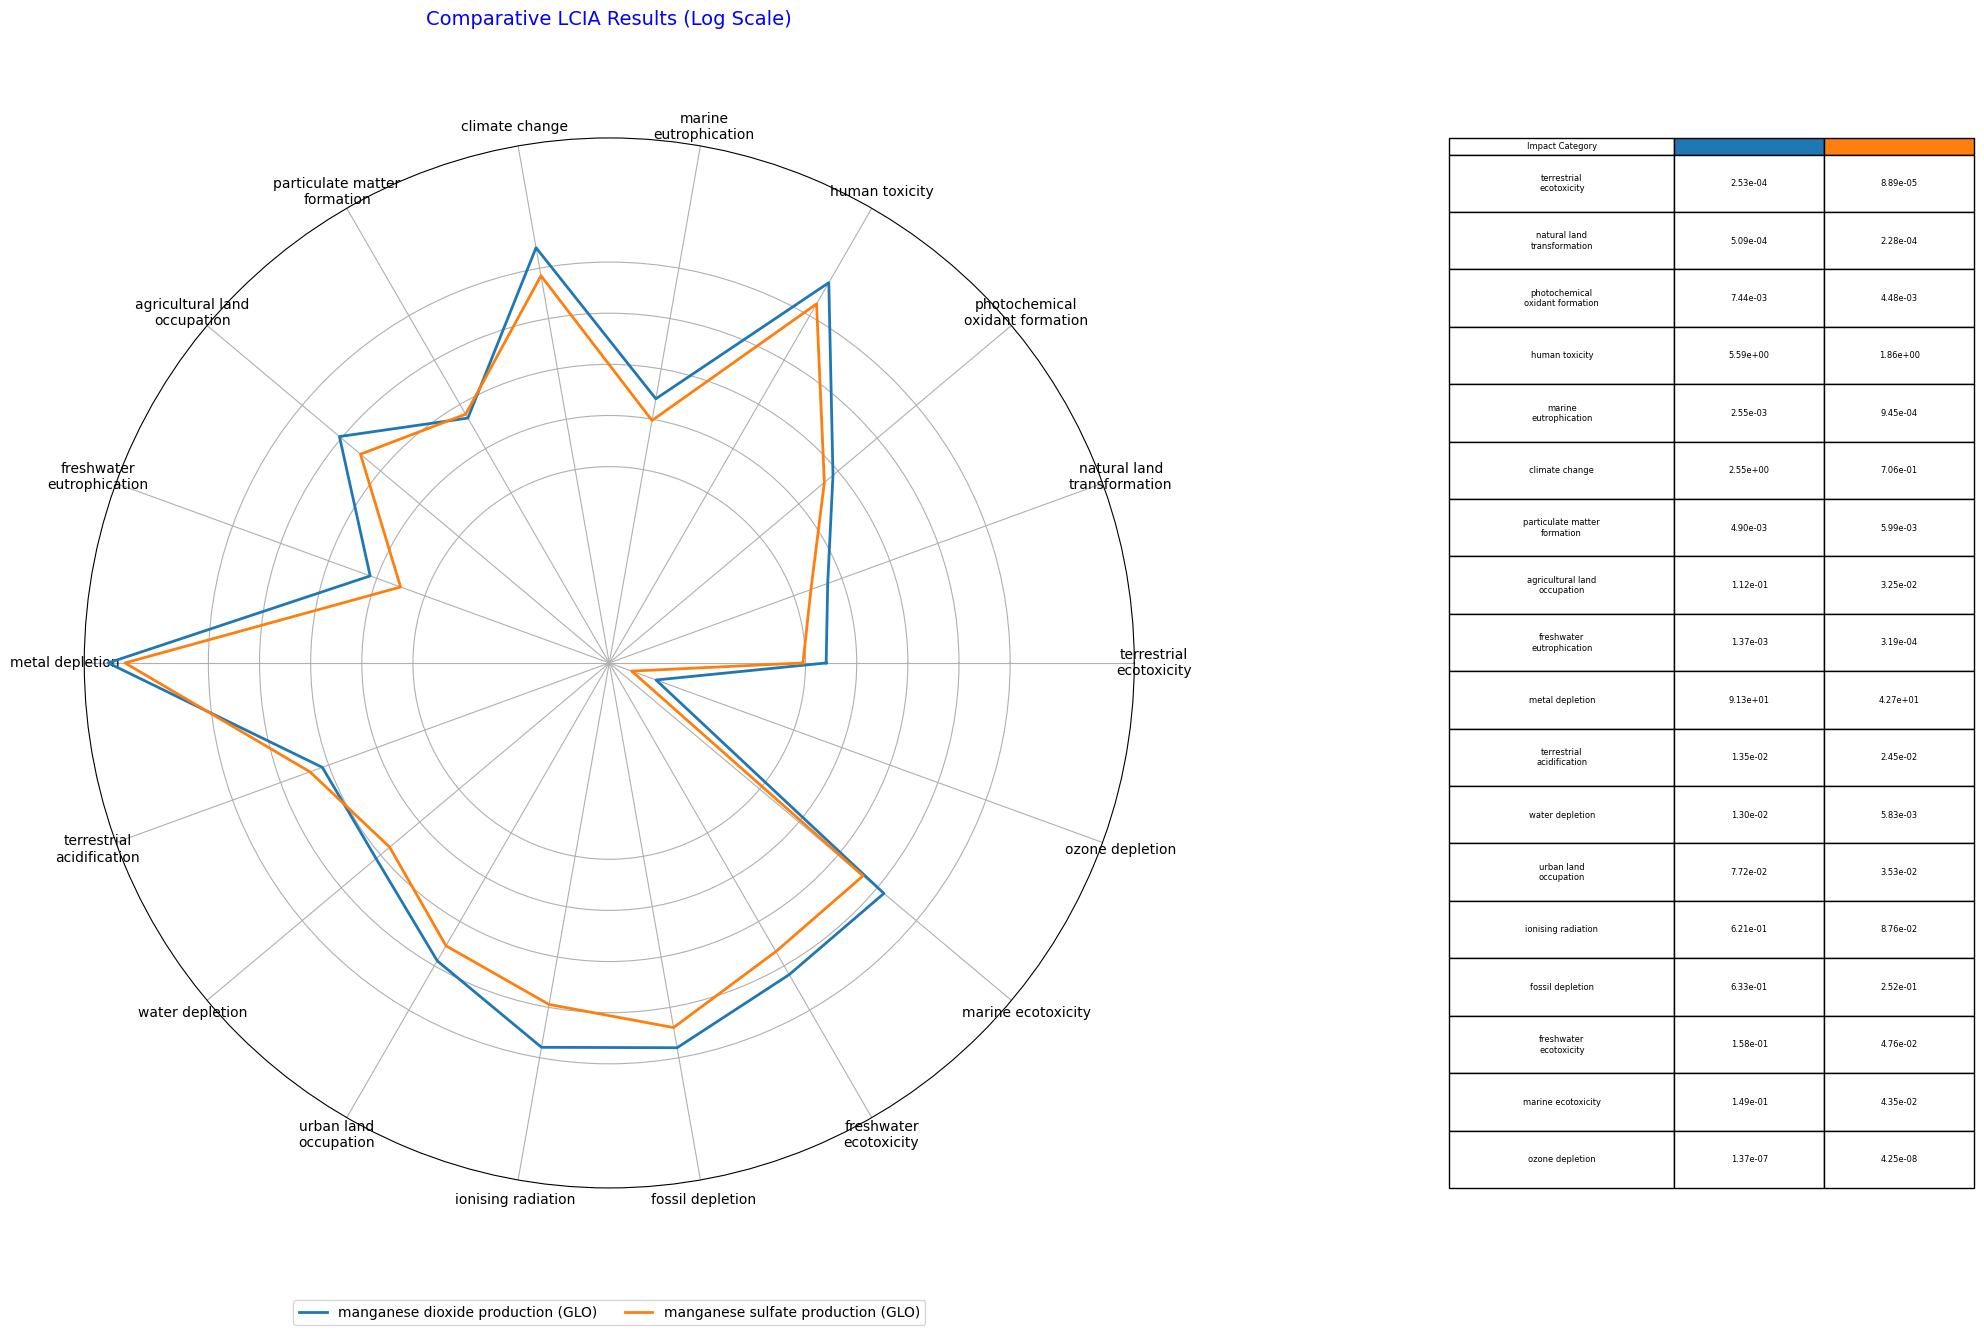

In [137]:
plot_comparative_radar_log_with_colored_table(comparative_results, recipe_midpoint_h)

# 6. Cobalt

# 7. battery cell, NMC-811

In [38]:
activity_name = 'battery cell, NMC-811'
activity = find_activity_by_name_product(db_name, activity_name)

In [41]:
list(activity.exchanges())

[Exchange: 1.0 kilogram 'battery cell, NMC-811' (kilogram, GLO, None) to 'battery cell, NMC-811' (kilogram, GLO, None)>,
 Exchange: 13.29 megajoule 'market for heat, district or industrial, natural gas' (megajoule, RoW, None) to 'battery cell, NMC-811' (kilogram, GLO, None)>,
 Exchange: 1.2616 kilowatt hour 'market group for electricity, medium voltage' (kilowatt hour, GLO, None) to 'battery cell, NMC-811' (kilogram, GLO, None)>,
 Exchange: 0.3773 kilogram 'cathode, NMC-811, for Li-ion battery' (kilogram, GLO, None) to 'battery cell, NMC-811' (kilogram, GLO, None)>,
 Exchange: 0.2181 kilogram 'anode, graphite, for Li-ion battery' (kilogram, GLO, None) to 'battery cell, NMC-811' (kilogram, GLO, None)>,
 Exchange: 0.1683 kilogram 'electrolyte, for Li-ion battery' (kilogram, GLO, None) to 'battery cell, NMC-811' (kilogram, GLO, None)>,
 Exchange: 0.1243 kilogram 'copper collector foil, for Li-ion battery' (kilogram, GLO, None) to 'battery cell, NMC-811' (kilogram, GLO, None)>,
 Exchange: 

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.007405880114087212
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0033629633997716134
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.061054898682830004
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 31.700584318667584
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.019264404039062665
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 14.007250211145301
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.06054861051128999
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.4515874854512975
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.011571757095925075
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 25.242680936233697
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.16304044282332805
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.1374525877139508
('ReCiPe Midpoint (H)', 'urban land occupati

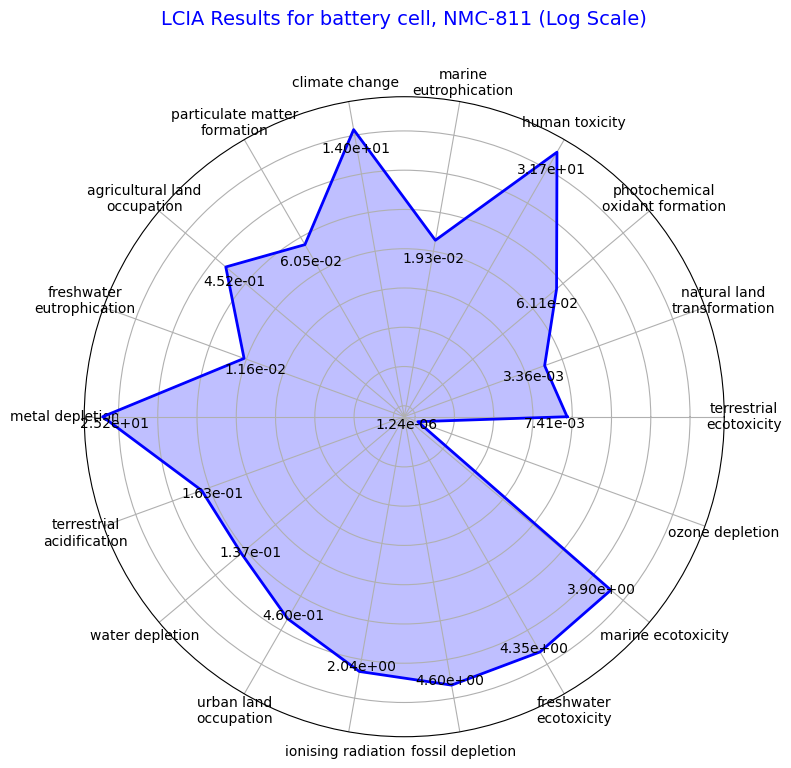

In [42]:
lcia_results = run_comprehensive_lcia(activity, recipe_midpoint_h)
plot_lcia_radar_log(lcia_results, activity_name)